## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from typing import Tuple, List, Type, Dict, Any
import matplotlib.pyplot as plt

### Data loading: "Евгений Онегин"


In [2]:
with open('onegin.txt', 'r', encoding='utf-8') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text_new = ''.join(text).lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

In [4]:
tokens = sorted(set(text_new))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
# dict <index>:<char>
# Your great code here
token_to_idx = {c: i for i, c in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
idx_to_token = {i: c for i, c in enumerate(tokens)}

In [6]:
encoded_text = np.array([token_to_idx[ch] for ch in text_new])

In [7]:
len(tokens)

83

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [8]:
n_classes = 83
batch_size = 16
seq_length = 50
n_epochs = 30

train_data, val_data = encoded_text[:len(encoded_text) * 8 // 10], encoded_text[len(encoded_text) * 8 // 10:]

In [9]:
class CharRNN_OHE(nn.Module):
    def __init__(self, n_classes, n_hidden = 256, num_layers=1):
        super(self.__class__, self).__init__()
        self.n_classes = n_classes
        self.n_hidden = n_hidden
        self.num_layers = num_layers
        
        self.emb = nn.Embedding.from_pretrained(torch.eye(self.n_classes))
        self.rnn = nn.RNN(self.n_classes, self.n_hidden, self.num_layers, batch_first=True)
        self.act = nn.LeakyReLU()
        self.drp = nn.Dropout()
        self.fc = nn.Linear(self.n_hidden, self.n_classes)
        
    def forward(self, x, hid = None):
        if hid == None:
            hid = torch.zeros(self.num_layers, x.size(0), self.n_hidden)
            
        x_ohe = self.emb(x)
        out, hid = self.rnn(x_ohe, hid)
        out = out.contiguous().view(-1, self.n_hidden)
        out = self.act(out)
        out = self.drp(out)
        out = self.fc(out)
        return out, hid

In [10]:
# idea from https://stackoverflow.com/questions/56201842/how-to-calculate-correct-batch-size-for-lstm
def get_batches(arr, batch_size, seq_length):
    batch_size_total = batch_size * seq_length
    n_batches = len(arr) // batch_size_total
    arr = arr[:n_batches * batch_size_total]
    arr = arr.reshape((batch_size, -1))

    for n in range(0, arr.shape[1], seq_length):
        x = arr[:, n:n + seq_length]
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n + seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

In [11]:
def train_model(net, train_data, val_data, criterion, 
                opt, lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau, lr_scheduler_params: Dict = {}):
    val_loss = []
    train_loss = []
    
    lr_scheduler = lr_scheduler_class(opt, **lr_scheduler_params)

    for epoch in range(n_epochs):
                
        ep_val_loss = []
        ep_train_loss = []

        net.train()
        for x, y in get_batches(train_data, batch_size, seq_length):
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            targets = targets.reshape((batch_size * seq_length,))
            
            net.zero_grad()
            output, hidden = net(inputs)

            loss = criterion(output, targets.long())
            loss.backward()
            
            ep_train_loss.append(loss.item())
            opt.step()
            
        net.eval()
        for x, y in get_batches(val_data, batch_size, seq_length):
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            targets = targets.reshape((batch_size * seq_length,))
            
            output, val_hidden = net(inputs)

            loss = criterion(output, targets.long()) 
            
            ep_val_loss.append(loss.item())
        
        lr_scheduler.step(loss.item())
        
        print(f'Epoch {epoch + 1} of {n_epochs}')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")

    return train_loss, val_loss

In [12]:
model_rnn = CharRNN_OHE(n_classes)
opt = torch.optim.Adam(model_rnn.parameters())
criterion = nn.CrossEntropyLoss()

train_loss, val_loss = train_model(model_rnn, train_data, val_data, criterion, opt)

Epoch 1 of 30
	  training loss: 3.424966
	validation loss: 3.297758
Epoch 2 of 30
	  training loss: 3.211228
	validation loss: 3.054621
Epoch 3 of 30
	  training loss: 2.956608
	validation loss: 2.819546
Epoch 4 of 30
	  training loss: 2.791560
	validation loss: 2.696342
Epoch 5 of 30
	  training loss: 2.699215
	validation loss: 2.609684
Epoch 6 of 30
	  training loss: 2.629499
	validation loss: 2.543167
Epoch 7 of 30
	  training loss: 2.576503
	validation loss: 2.495577
Epoch 8 of 30
	  training loss: 2.528444
	validation loss: 2.444764
Epoch 9 of 30
	  training loss: 2.488033
	validation loss: 2.413101
Epoch 10 of 30
	  training loss: 2.450494
	validation loss: 2.380394
Epoch 11 of 30
	  training loss: 2.417427
	validation loss: 2.348957
Epoch 12 of 30
	  training loss: 2.388027
	validation loss: 2.329302
Epoch 13 of 30
	  training loss: 2.367143
	validation loss: 2.302495
Epoch 14 of 30
	  training loss: 2.340757
	validation loss: 2.284272
Epoch 15 of 30
	  training loss: 2.322108
	

Plot the loss function (axis X: number of epochs, axis Y: loss function).

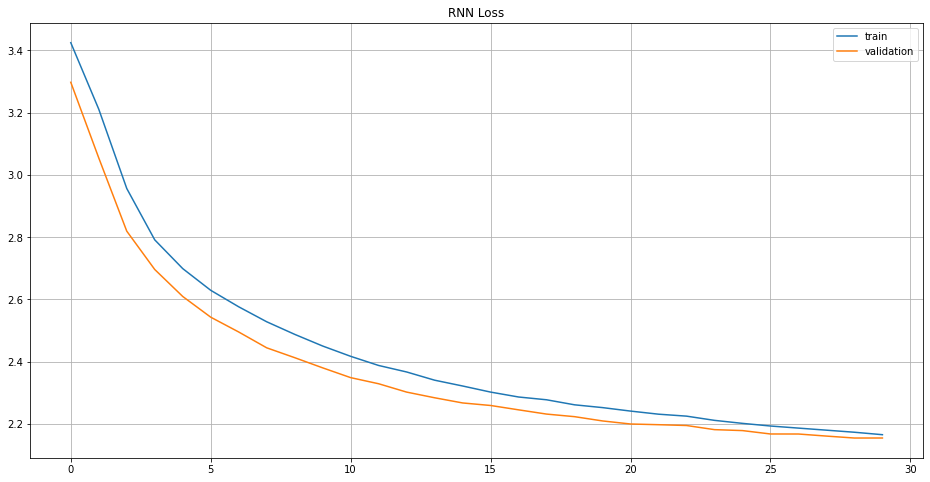

In [13]:
plt.figure(figsize=(16, 8))
plt.title('RNN Loss')
plt.xlabel = 'Epochs'
plt.ylabel = 'Value'
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.grid()
plt.legend(); 

In [14]:
def generate_sample(char_rnn, seed_phrase=' привет', max_length=200, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    char_rnn.eval()
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    hid_state = None
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, hid_state = char_rnn(x_sequence[:, :, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(x_sequence[:, :, -1], hid_state)
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix[None, :, :]], dim=2)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

In [23]:
# An example of generated text.
print(generate_sample(model_rnn))

 приветя суперет сохолы
моу пормолманыи поглял вся,
ило вмя на тофмое внетя
хранольне справно сподынье
он козврый, предум нашоли бог,
вым мидцам, кокдать, е мне тотной
бы гражанствые бостинька тапрожа


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [17]:
class CharLSTM_OHE(nn.Module):
    def __init__(self, n_classes, n_hidden = 256, num_layers = 1):
        super(self.__class__, self).__init__()
        self.n_classes = n_classes
        self.n_hidden = n_hidden
        self.num_layers = num_layers
        
        self.emb = nn.Embedding.from_pretrained(torch.eye(self.n_classes))
        self.lstm = nn.LSTM(self.n_classes, self.n_hidden, self.num_layers, batch_first=True)
        self.act = nn.LeakyReLU()
        self.drp = nn.Dropout()
        self.fc = nn.Linear(self.n_hidden, self.n_classes)
        
    def forward(self, x, hid = None):
        if hid == None:
            hid = (torch.zeros(self.num_layers, x.size(0), self.n_hidden), 
                   torch.zeros(self.num_layers, x.size(0), self.n_hidden))
            
        x_ohe = self.emb(x)
        out, hid = self.lstm(x_ohe, hid)
        out = out.contiguous().view(-1, self.n_hidden)
        out = self.act(out)
        out = self.drp(out)
        out = self.fc(out)
        return out, hid

In [18]:
model_lstm = CharLSTM_OHE(n_classes)
opt = torch.optim.Adam(model_lstm.parameters())
criterion = nn.CrossEntropyLoss()

train_loss_lstm, val_loss_lstm = train_model(model_lstm, train_data, val_data, criterion, opt)

Epoch 1 of 30
	  training loss: 3.457567
	validation loss: 3.318981
Epoch 2 of 30
	  training loss: 3.273449
	validation loss: 3.182246
Epoch 3 of 30
	  training loss: 3.093434
	validation loss: 2.976729
Epoch 4 of 30
	  training loss: 2.936037
	validation loss: 2.843268
Epoch 5 of 30
	  training loss: 2.830695
	validation loss: 2.752427
Epoch 6 of 30
	  training loss: 2.759535
	validation loss: 2.691929
Epoch 7 of 30
	  training loss: 2.709828
	validation loss: 2.648624
Epoch 8 of 30
	  training loss: 2.671672
	validation loss: 2.613131
Epoch 9 of 30
	  training loss: 2.635517
	validation loss: 2.573726
Epoch 10 of 30
	  training loss: 2.601854
	validation loss: 2.542482
Epoch 11 of 30
	  training loss: 2.573730
	validation loss: 2.512663
Epoch 12 of 30
	  training loss: 2.544042
	validation loss: 2.485241
Epoch 13 of 30
	  training loss: 2.520295
	validation loss: 2.472598
Epoch 14 of 30
	  training loss: 2.501478
	validation loss: 2.446303
Epoch 15 of 30
	  training loss: 2.483352
	

Plot the loss function of the number of epochs. Does the final loss become better?

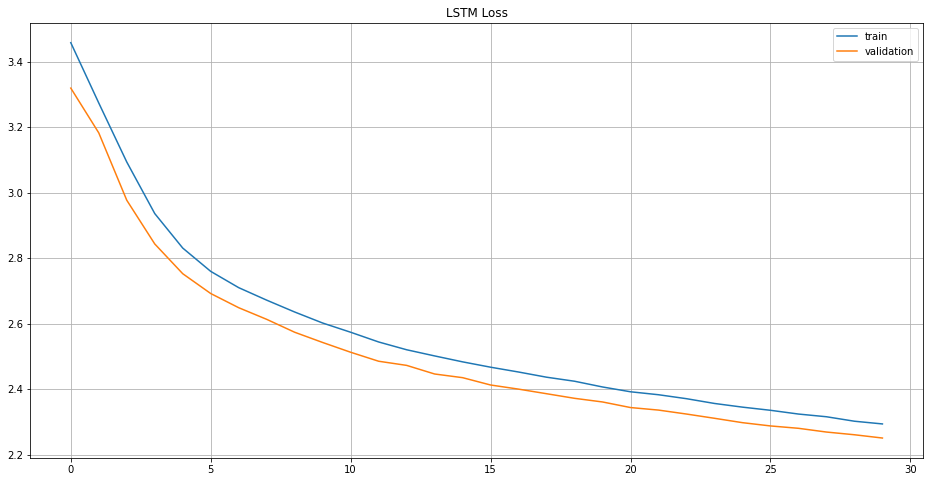

In [19]:
plt.figure(figsize=(16, 8))
plt.title('LSTM Loss')
plt.xlabel = 'Epochs'
plt.ylabel = 'Value'
plt.plot(train_loss_lstm, label='train')
plt.plot(val_loss_lstm, label='validation')
plt.grid()
plt.legend(); 

In [20]:
print(generate_sample(model_lstm))

 приветсти?
вотью и ссросток комынея.
покодинный нобеднил,
тол живти лен тлеть (мые ни рис,
ею сне до путя, его
но пулцумвнодо зель,
восклу не менал, сноюлаблись,
ни ток налсней д ужуи, кере!
и бго и 


**Сonclusion:** Final loss did not become better, than RNN loss. Maybe, it is because of some another hacks I used in model's architecture.

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [21]:
# Text generation with different temperature values here
for i in [0.001, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0]:
    print("Temperature = ", i)
    print(generate_sample(model_lstm, temperature = i),'\n')

Temperature =  0.001
 приветь и страстальный страда
на сторо не сторовой стора
не сторо не сторо не стора
и страсталь он восто не стора
и страсталь он восто не стора
и страсталь он восто не стора
и страсталь он восто не с 

Temperature =  0.1
 приветь сердце не страна,
постоль и поленный страста,
на страстали сторит сердце странит,
и стором не странит сердце не стора
и придоть восто сторит серда
постовольно в соловой сторо
не сторо сторит  

Temperature =  0.2
 приветь оно стольной,
и моло странит сердце стара
продеть и в сереста серет
на воло в сторовой на скора
на сторой поровольной воло



xxii

и в серда с сторо не не страдный
весталь и примил не в сере 

Temperature =  0.5
 приветь милений,
посна ветаро порененный,
сость на сворный весней этов.



vii

так в сенеги там сканит,
да веда замена мостых
он голубим и лебь верод
и воробовне в наскредил.



xxviii

на на  столи 

Temperature =  1.0
 приветь пруядел,
меня грануведь? жещенай
спореляны блув.
вогеча чевно
мулыть ос идот.
бо е

**Сonclusion:** 
- As we can see, when temperature is high - predicted probabilities become more uniform and when temperature is low - they become more determenistic.
- Most readable text is for temperature = 0.5

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [22]:
# Saving and loading code here
torch.save(model_lstm, './lstm_pushkin.pth')

model_new = torch.load('./lstm_pushkin.pth')
print(generate_sample(model_new))

 привет,
веетмиы в серщестинье;
утурещат комни свечу,
дланолаке семданет,
качтали, быстелний шеюз;
депянит но трака! вбова!,
как мвною жевой и ксрадна
в чезстал пазак молкой угоя,
таталусва пок:релет:


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)